In [2]:
from pathlib import Path
import shutil
import cv2
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

import os
import numpy as np
import torch
import matplotlib.pyplot as plt

import torchvision.transforms.functional as F
from torchvision.io import read_image
from torchvision.utils import draw_segmentation_masks, draw_bounding_boxes
from torchvision.ops import masks_to_boxes
from torchvision import transforms

import sys

sys.path.insert(0, "../../src/utils")
from splitter import Splitter

In [3]:
def pascal_voc_to_yolo(x1, y1, x2, y2, image_w, image_h):
    return [
        ((x2 + x1) / (2 * image_w)),
        ((y2 + y1) / (2 * image_h)),
        (x2 - x1) / image_w,
        (y2 - y1) / image_h,
    ]


def binarize_tensor(tensor, threshold=0.01):
    binary_tensor = torch.zeros_like(tensor)
    binary_tensor[tensor > threshold] = 1.0
    return binary_tensor


plt.rcParams["savefig.bbox"] = "tight"


def show(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fix, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = F.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])


def safety_folder_creation(dirpath: str) -> None:
    dirpath = Path(dirpath)
    if dirpath.exists() and dirpath.is_dir():
        shutil.rmtree(dirpath)
    os.mkdir(dirpath)

In [7]:
def convert_mask_to_bboxes(img_path, mask_path, yolo_format=False):
    img = read_image(img_path)
    transform = transforms.Compose(
        [
            # transforms.Resize((480, 640)),
            transforms.ToTensor(),
        ]
    )

    mask = Image.open(mask_path).convert("L")
    mask = transform(mask)
    mask = binarize_tensor(mask)
    mask = mask.type(torch.uint8)
    mask = mask.squeeze()

    # We get the unique colors, as these would be the object ids.
    obj_ids = torch.unique(mask)

    # first id is the background, so remove it.
    obj_ids = obj_ids[1:]

    # split the color-encoded mask into a set of boolean masks.
    # Note that this snippet would work as well if the masks were float values instead of ints.
    masks = mask == obj_ids[:, None, None]

    boxes = masks_to_boxes(masks)
    result_boxes = []
    for box in boxes:
        x1, y1, x2, y2 = np.array(box, dtype=int)
        image_h, image_w = img.shape[1], img.shape[2]
        if yolo_format:
            yolo_box = pascal_voc_to_yolo(x1, y1, x2, y2, image_w, image_h)
            result_boxes.append(yolo_box)
        else:
            result_boxes.append([x1, y1, x2, y2])
    return result_boxes

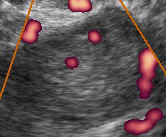

In [21]:
ASSETS_DIRECTORY = "../../ovaries_segmentation/data/our_data/Норма/"
img_path = os.path.join(
    ASSETS_DIRECTORY, "patient_00001_2019.03.23_16_6_photo_0000.jpeg"
)
mask_path = os.path.join(
    ASSETS_DIRECTORY, "patient_00001_2019.03.23_16_6_photo_0000_ovar.png"
)
img = Image.open(img_path)
mask = Image.open(mask_path)

box = convert_mask_to_bboxes(img_path, mask_path)[0]
box[0] = max(0, box[0] - 10)
box[1] = max(0, box[1] - 10)
box[2] = min(img.size[0], box[2] + 10)
box[3] = min(img.size[1], box[3] + 10)

img.crop(box)

In [33]:
class FollicleOvariesDataset(torch.utils.data.Dataset):
    def __init__(self, dataset_files, transform=None):
        self.dataset_files = dataset_files
        self.images = []
        self.ovar_masks = []
        self.foll_masks = []
        self._get_paths()
        self.transform = transform

    def _get_paths(self):
        for path in self.dataset_files:
            path = Path(path)
            if path.is_file():
                if "_ovar" in str(path):
                    self.ovar_masks.append(path)
                elif "_foll" in str(path):
                    self.foll_masks.append(path)
                else:
                    self.images.append(path)
        self.images.sort()
        self.ovar_masks.sort()
        self.foll_masks.sort()

        # test for mismatchs
        for img_p, ovar_mask_p, foll_masks_p in zip(
            self.images, self.ovar_masks, self.foll_masks
        ):
            img_source_name = ".".join(str(img_p).split(".")[:-1])
            ovar_mask_source_name = ".".join(str(ovar_mask_p).split(".")[:-1]).replace(
                "_ovar", ""
            )
            foll_masks_source_name = ".".join(
                str(foll_masks_p).split(".")[:-1]
            ).replace("_foll", "")

            assert (
                img_source_name == ovar_mask_source_name
            ), f"mismatch {img_source_name}\t{ovar_mask_source_name}"
            assert (
                img_source_name == foll_masks_source_name
            ), f"mismatch {img_source_name}\t{foll_masks_source_name}"
            assert (
                foll_masks_source_name == ovar_mask_source_name
            ), f"mismatch {foll_masks_source_name}\t{ovar_mask_source_name}"

In [34]:
splitter = Splitter(data_path="../../ovaries_segmentation/data/transformed_data/")
train_sets, test_sets = splitter.get_train_test_sets()
samples = train_sets[0] + test_sets[0]

foll_ovar_dataset = FollicleOvariesDataset(samples)

In [56]:
i = 0
for img_path, ovar_mask_path, foll_mask_path in zip(
    foll_ovar_dataset.images, foll_ovar_dataset.ovar_masks, foll_ovar_dataset.foll_masks
):
    img = Image.open(img_path)
    ovar_mask = Image.open(ovar_mask_path)
    foll_mask = Image.open(foll_mask_path)

    print(img_path, ovar_mask_path, foll_mask_path)
    boxes = convert_mask_to_bboxes(str(img_path), str(ovar_mask_path))
    if boxes:
        box = boxes[0]
    else:
        continue
    box[0] = max(0, box[0] - 10)
    box[1] = max(0, box[1] - 10)
    box[2] = min(img.size[0], box[2] + 10)
    box[3] = min(img.size[1], box[3] + 10)

    croped_img = img.crop(box)
    cropped_ovar_mask = ovar_mask.crop(box)
    cropped_foll_mask = foll_mask.crop(box)

    save_img_path = os.path.join("../data", "/".join(str(img_path).split("\\")[-2:]))
    save_ovar_path = os.path.join(
        "../data", "/".join(str(ovar_mask_path).split("\\")[-2:])
    )
    save_foll_path = os.path.join(
        "../data", "/".join(str(foll_mask_path).split("\\")[-2:])
    )

    croped_img.save(save_img_path)
    cropped_ovar_mask.save(save_ovar_path)
    cropped_foll_mask.save(save_foll_path)

..\..\ovaries_segmentation\data\transformed_data\Мало\patient_000043_26.06.2021_16_03_photo_0012.jpeg ..\..\ovaries_segmentation\data\transformed_data\Мало\patient_000043_26.06.2021_16_03_photo_0012_ovar.png ..\..\ovaries_segmentation\data\transformed_data\Мало\patient_000043_26.06.2021_16_03_photo_0012_foll.png
..\..\ovaries_segmentation\data\transformed_data\Мало\patient_000043_26.06.2021_16_03_photo_0021.jpeg ..\..\ovaries_segmentation\data\transformed_data\Мало\patient_000043_26.06.2021_16_03_photo_0021_ovar.png ..\..\ovaries_segmentation\data\transformed_data\Мало\patient_000043_26.06.2021_16_03_photo_0021_foll.png
..\..\ovaries_segmentation\data\transformed_data\Мало\patient_000043_26.06.2021_16_03_photo_0028.jpeg ..\..\ovaries_segmentation\data\transformed_data\Мало\patient_000043_26.06.2021_16_03_photo_0028_ovar.png ..\..\ovaries_segmentation\data\transformed_data\Мало\patient_000043_26.06.2021_16_03_photo_0028_foll.png
..\..\ovaries_segmentation\data\transformed_data\Мало\pati

=================================== Архив ===================================

In [46]:
img_path, ovar_mask_path, foll_mask_path = (
    r"..\..\ovaries_segmentation\data\transformed_data\Мало\patient_00014_2019.07.13_29_2_photo_0127.jpeg",
    r"..\..\ovaries_segmentation\data\transformed_data\Мало\patient_00014_2019.07.13_29_2_photo_0127_ovar.png",
    r"..\..\ovaries_segmentation\data\transformed_data\Мало\patient_00014_2019.07.13_29_2_photo_0127_foll.png",
)
img = Image.open(img_path)
ovar_mask = Image.open(ovar_mask_path)
foll_mask = Image.open(foll_mask_path)

if convert_mask_to_bboxes(str(img_path), str(ovar_mask_path)):
    print(1)

In [49]:
FOLDERS_PATH = "../data/our_data/"
segmentation_folders = [
    os.path.join(FOLDERS_PATH, "Норма"),
    os.path.join(FOLDERS_PATH, "МФЯ"),
    os.path.join(FOLDERS_PATH, "Мало"),
    os.path.join(FOLDERS_PATH, "Менопауза"),
]

TRAIN_IMAGES_PATH = "../data/detection/train/images"
TRAIN_LABELS_PATH = "../data/detection/train/labels"
VAL_IMAGES_PATH = "../data/detection/val/images"
VAL_LABELS_PATH = "../data/detection/val/labels"
safety_folder_creation(TRAIN_IMAGES_PATH)
safety_folder_creation(TRAIN_LABELS_PATH)
safety_folder_creation(VAL_IMAGES_PATH)
safety_folder_creation(VAL_LABELS_PATH)

splitter = Splitter(data_path="../data/transformed_data/")
train_sets, test_sets = splitter.get_train_test_sets()
train_set = train_sets[0]
test_set = test_sets[0]

name = 0
seg_dataset = OvariesDataset(dataset_files=train_set)
for img_path, mask_path in zip(seg_dataset.images, seg_dataset.masks):
    shutil.copy(img_path, os.path.join(TRAIN_IMAGES_PATH, f"{name}.jpg"))
    bboxes = convert_mask_to_bboxes(str(img_path), str(mask_path))
    with open(os.path.join(TRAIN_LABELS_PATH, f"{name}.txt"), "w") as f:
        for box in bboxes:
            line = [0] + box
            line = " ".join([str(ch) for ch in line])
            f.write(line)
    name += 1

seg_dataset = OvariesDataset(dataset_files=test_set)
for img_path, mask_path in zip(seg_dataset.images, seg_dataset.masks):
    shutil.copy(img_path, os.path.join(VAL_IMAGES_PATH, f"{name}.jpg"))
    bboxes = convert_mask_to_bboxes(str(img_path), str(mask_path))
    with open(os.path.join(VAL_LABELS_PATH, f"{name}.txt"), "w") as f:
        for box in bboxes:
            line = [0] + box
            line = " ".join([str(ch) for ch in line])
            f.write(line)
    name += 1

In [32]:
img_path, mask_path = str(seg_dataset.images[3]), str(seg_dataset.masks[3])

img = read_image(img_path)
transform = transforms.Compose(
    [
        # transforms.Resize((480, 640)),
        transforms.ToTensor(),
    ]
)

mask = Image.open(mask_path).convert("L")
print(mask.size)
mask = transform(mask)
mask = binarize_tensor(mask)
mask = mask.type(torch.uint8)
mask = mask.squeeze()

# We get the unique colors, as these would be the object ids.
obj_ids = torch.unique(mask)

# first id is the background, so remove it.
obj_ids = obj_ids[1:]

# split the color-encoded mask into a set of boolean masks.
# Note that this snippet would work as well if the masks were float values instead of ints.
masks = mask == obj_ids[:, None, None]

boxes = masks_to_boxes(masks)
yolo_boxes = []
for box in boxes:
    x1, y1, x2, y2 = np.array(box, dtype=int)
    image_w, image_h = img.shape[1], img.shape[2]
    yolo_box = pascal_voc_to_yolo(x1, y1, x2, y2, image_w, image_h)
    yolo_boxes.append(yolo_box)

yolo_boxes

(604, 338)


[[1.121301775147929,
  0.12417218543046357,
  0.35502958579881655,
  0.1423841059602649]]

In [30]:
img.shape

torch.Size([3, 338, 604])

In [29]:
boxes

tensor([[319.,  32., 439., 118.]])

In [7]:
splitter = Splitter(data_path="../data/transformed_data/")
train_sets, test_sets = splitter.get_train_test_sets()
train_sets

[['../data/transformed_data/Мало\\patient_00014_2019.07.13_29_2_photo_0000.jpeg',
  '../data/transformed_data/Мало\\patient_00014_2019.07.13_29_2_photo_0000_foll.png',
  '../data/transformed_data/Мало\\patient_00014_2019.07.13_29_2_photo_0000_ovar.png',
  '../data/transformed_data/Мало\\patient_00014_2019.07.13_29_2_photo_0007.jpeg',
  '../data/transformed_data/Мало\\patient_00014_2019.07.13_29_2_photo_0007_foll.png',
  '../data/transformed_data/Мало\\patient_00014_2019.07.13_29_2_photo_0007_ovar.png',
  '../data/transformed_data/Мало\\patient_00014_2019.07.13_29_2_photo_0011.jpeg',
  '../data/transformed_data/Мало\\patient_00014_2019.07.13_29_2_photo_0011_foll.png',
  '../data/transformed_data/Мало\\patient_00014_2019.07.13_29_2_photo_0011_ovar.png',
  '../data/transformed_data/Мало\\patient_00014_2019.07.13_29_2_photo_0015.jpeg',
  '../data/transformed_data/Мало\\patient_00014_2019.07.13_29_2_photo_0015_foll.png',
  '../data/transformed_data/Мало\\patient_00014_2019.07.13_29_2_photo_

In [5]:
splt = Splitter(data_path="../data/our_data/")
splt.get_unique_patients_in_group(segmentation_folders[0])

defaultdict(list,
            {'patient_00001': ['../data/our_data/Норма\\patient_00001_2019.03.23_16_6_photo_0000.jpeg',
              '../data/our_data/Норма\\patient_00001_2019.03.23_16_6_photo_0000_foll.png',
              '../data/our_data/Норма\\patient_00001_2019.03.23_16_6_photo_0000_ovar.png',
              '../data/our_data/Норма\\patient_00001_2019.03.23_16_6_photo_0008.jpeg',
              '../data/our_data/Норма\\patient_00001_2019.03.23_16_6_photo_0008_foll.png',
              '../data/our_data/Норма\\patient_00001_2019.03.23_16_6_photo_0008_ovar.png',
              '../data/our_data/Норма\\patient_00001_2019.03.23_16_6_photo_0014.jpeg',
              '../data/our_data/Норма\\patient_00001_2019.03.23_16_6_photo_0014_foll.png',
              '../data/our_data/Норма\\patient_00001_2019.03.23_16_6_photo_0014_ovar.png',
              '../data/our_data/Норма\\patient_00001_2019.03.23_16_6_photo_0020.jpeg',
              '../data/our_data/Норма\\patient_00001_2019.03.23_16_6_ph

In [ ]:
ASSETS_DIRECTORY = "../data/our_data/Норма/"
img_path = os.path.join(
    ASSETS_DIRECTORY, "patient_00001_2019.03.23_16_6_photo_0000.jpeg"
)
mask_path = os.path.join(
    ASSETS_DIRECTORY, "patient_00001_2019.03.23_16_6_photo_0000_ovar.png"
)
img = read_image(img_path)

transform = transforms.Compose(
    [
        # transforms.Resize((480, 640)),
        transforms.ToTensor(),
    ]
)

mask = Image.open(mask_path).convert("L")
mask = transform(mask)
mask = binarize_tensor(mask)
mask = mask.type(torch.uint8)
mask = mask.squeeze()

In [ ]:
# We get the unique colors, as these would be the object ids.
obj_ids = torch.unique(mask)

# first id is the background, so remove it.
obj_ids = obj_ids[1:]

# split the color-encoded mask into a set of boolean masks.
# Note that this snippet would work as well if the masks were float values instead of ints.
masks = mask == obj_ids[:, None, None]

drawn_masks = []
for mask in masks:
    drawn_masks.append(draw_segmentation_masks(img, mask, alpha=0.8, colors="blue"))


boxes = masks_to_boxes(masks)
print(boxes.size())
print(boxes)

x1, y1, x2, y2 = np.array(boxes.squeeze(), dtype=int)
image_w, image_h = img.shape[1], img.shape[2]
[0] + pascal_voc_to_yolo(x1, y1, x2, y2, image_w, image_h)

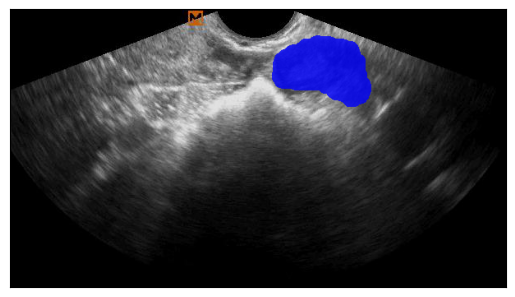

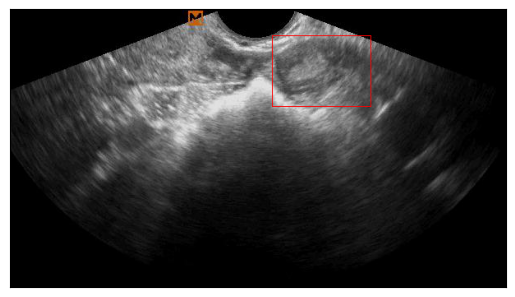

In [34]:
drawn_masks = []
for mask in masks:
    drawn_masks.append(draw_segmentation_masks(img, mask, alpha=0.8, colors="blue"))

show(drawn_masks)
drawn_boxes = draw_bounding_boxes(img, boxes, colors="red")
show(drawn_boxes)

In [39]:
img.shape[2]

604